# recreate a coadd

Get all the images that went into a coadd, and then rebuild it.

Maybe tweak some of the image combination parameters for fun, or just rebuild for a few months of observations.

## set up

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

import pandas
pandas.set_option('display.max_rows', 1000)

import lsst.daf.butler as dafButler

import lsst.geom
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

from astropy.wcs import WCS

## choose DP0.2 collection

Collection chosen to use same image as in NB 01, the pretty cluster

In [2]:
repo = 's3://butler-us-central1-panda-dev/dc2/butler-external.yaml'
collection = '2.2i/runs/DP0.2/v23_0_1_rc1/PREOPS-905/pilot_tract4431'

butler = dafButler.Butler(repo, collections=collection)

## choose a coadd

same as we use for NB 01

In [3]:
my_spherePoint = lsst.geom.SpherePoint(55.745834*lsst.geom.degrees,
                                       -32.269167*lsst.geom.degrees)
print(my_spherePoint)

skymap = butler.get('skyMap')
my_tract = skymap.findTract(my_spherePoint)
my_patch = my_tract.findPatch(my_spherePoint)
my_patch_id = my_tract.getSequentialPatchIndex(my_patch)
print('my_tract = ', my_tract)
print('my_patch = ', my_patch)
print('my_patch_id = ', my_patch_id)

dataId = {'band': 'i', 'tract': 4431, 'patch': 17}
deepCoadd = butler.get('deepCoadd', dataId=dataId)

(55.7458340000, -32.2691670000)
my_tract =  TractInfo(id=4431)
my_patch =  PatchInfo(index=Index2D(x=3, y=2))
my_patch_id =  17


show the coadd

In [ ]:
# fig = plt.figure(figsize=(6, 4))
# afw_display = afwDisplay.Display(1)
# afw_display.scale('asinh', 'zscale')
# afw_display.mtv(deepCoadd.image)
# plt.gca().axis('off')

get more info about the pixel data

In [4]:
imgdata = np.asarray( deepCoadd.image.array, dtype='float' )
print( np.min(imgdata), np.mean(imgdata), np.max(imgdata) )

-0.32105696201324463 0.1392329267664109 1380.316162109375


## identify coadd inputs

In [5]:
coadd_inputs = butler.get("deepCoadd_calexp.coaddInputs", dataId)

In [6]:
coadd_inputs_ccds_table = coadd_inputs.ccds.asAstropy()

In [7]:
coadd_inputs_ccds_table

id,bbox_min_x,bbox_min_y,bbox_max_x,bbox_max_y,ccd,visit,goodpix,weight,filter
,pix,pix,pix,pix,,,,,
int64,int32,int32,int32,int32,int32,int64,int32,float64,str32
227922000,0,0,4071,3999,0,227922,1512880,1.745271720648272,i_sim_1.4
951274001,0,0,4071,3999,1,951274,1577144,4.326007963992991,i_sim_1.4
951274002,0,0,4071,3999,2,951274,154692,4.326007963992991,i_sim_1.4
951274004,0,0,4071,3999,4,951274,10850788,4.326007963992991,i_sim_1.4
951274005,0,0,4071,3999,5,951274,3615362,4.326007963992991,i_sim_1.4
951274007,0,0,4071,3999,7,951274,3671,4.326007963992991,i_sim_1.4
420782005,0,0,4071,3999,5,420782,9876512,4.539556638143641,i_sim_1.4
420782008,0,0,4071,3999,8,420782,828705,4.539556638143641,i_sim_1.4


In [ ]:
# coadd_inputs_visits_table = coadd_inputs.visits.asAstropy()

In [ ]:
# coadd_inputs_visits_table

## retrieve just one of the calexps which contributed

In [8]:
use_detector = coadd_inputs_ccds_table['ccd'][0]
use_visit = coadd_inputs_ccds_table['visit'][0]

print('ccd, visit = ', use_detector, use_visit)
calexp = butler.get('calexp', detector=use_detector, visit=use_visit)

ccd, visit =  0 227922


In [ ]:
# fig = plt.figure(figsize=(6, 4))
# afw_display = afwDisplay.Display(1)
# afw_display.scale('asinh', 'zscale')
# afw_display.mtv(calexp.image)
# plt.gca().axis('off')

In [9]:
imgdata = np.asarray( calexp.image.array, dtype='float' )
print( np.min(imgdata), np.mean(imgdata), np.max(imgdata) )

-380.42010498046875 6.565610028781216 130776.6640625


bounding box (is also in the table above)

In [10]:
calexp_bbox = butler.get('calexp.bbox', detector=use_detector, visit=use_visit)
print( calexp_bbox.beginX, calexp_bbox.beginY, calexp_bbox.endX, calexp_bbox.endY )
print( calexp_bbox.getCorners )

0 0 4072 4000
<bound method PyCapsule.getCorners of Box2I(corner=Point2I(0, 0), dimensions=Extent2I(4072, 4000))>


### do the coadd and the calexp look like they overlap?

no they don't...

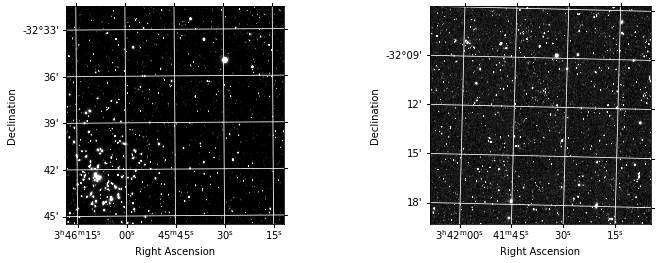

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

plt.subplot(1, 2, 1, projection=WCS(deepCoadd.getWcs().getFitsMetadata()))
plt.imshow(deepCoadd.image.array, cmap='gray', vmin=0, vmax=2, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')

plt.subplot(1, 2, 2,  projection=WCS(calexp.getWcs().getFitsMetadata()))
plt.imshow(calexp.image.array, cmap='gray', vmin=-10, vmax=100, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')

plt.show()

## plot boxes for all overlapping visits

demo how to get corners ra,dec

In [12]:
deepCoadd_bbox = butler.get('deepCoadd.bbox', dataId=dataId)
calexp_bbox = butler.get('calexp.bbox', detector=use_detector, visit=use_visit)

deepCoadd_wcs = butler.get('deepCoadd.wcs', dataId=dataId)
calexp_wcs = butler.get('calexp.wcs', detector=use_detector, visit=use_visit)

deepCoadd_meta = WCS(deepCoadd_wcs.getFitsMetadata())
calexp_meta = WCS(calexp_wcs.getFitsMetadata())

X0 = deepCoadd_bbox.beginX
Y0 = deepCoadd_bbox.beginY
X1 = deepCoadd_bbox.endX
Y1 = deepCoadd_bbox.endY
corners1 = [ deepCoadd_meta.pixel_to_world(X0, Y0), 
             deepCoadd_meta.pixel_to_world(X0, Y1), 
             deepCoadd_meta.pixel_to_world(X1, Y1), 
             deepCoadd_meta.pixel_to_world(X1, Y0) ]
print('corners of the deepCoadd: ', corners1)
del X0,Y0,X1,Y1

X0 = calexp_bbox.beginX
Y0 = calexp_bbox.beginY
X1 = calexp_bbox.endX
Y1 = calexp_bbox.endY
corners2 = [ calexp_meta.pixel_to_world(X0, Y0), 
             calexp_meta.pixel_to_world(X0, Y1), 
             calexp_meta.pixel_to_world(X1, Y1), 
             calexp_meta.pixel_to_world(X1, Y0) ]
print('corners of the calexp: ', corners2)
del X0,Y0,X1,Y1

del deepCoadd_bbox, calexp_bbox
del deepCoadd_wcs, calexp_wcs
del deepCoadd_meta, calexp_meta
del corners2

corners of the deepCoadd:  [<SkyCoord (ICRS): (ra, dec) in deg
    (55.79016376, -32.32222538)>, <SkyCoord (ICRS): (ra, dec) in deg
    (55.78981244, -32.08889655)>, <SkyCoord (ICRS): (ra, dec) in deg
    (55.51440424, -32.08889641)>, <SkyCoord (ICRS): (ra, dec) in deg
    (55.51405258, -32.32222524)>]
corners of the calexp:  [<SkyCoord (ICRS): (ra, dec) in deg
    (55.53613413, -32.32159987)>, <SkyCoord (ICRS): (ra, dec) in deg
    (55.54250098, -32.10015306)>, <SkyCoord (ICRS): (ra, dec) in deg
    (55.27597783, -32.09489925)>, <SkyCoord (ICRS): (ra, dec) in deg
    (55.2690443, -32.31637282)>]


put the deepCoadd corners in an array, for plotting later

In [13]:
corners_deepCoadd = np.zeros( (4,2), dtype='float' )

corners_deepCoadd[0][0] = corners1[0].ra.deg
corners_deepCoadd[1][0] = corners1[1].ra.deg
corners_deepCoadd[2][0] = corners1[2].ra.deg
corners_deepCoadd[3][0] = corners1[3].ra.deg
corners_deepCoadd[0][1] = corners1[0].dec.deg
corners_deepCoadd[1][1] = corners1[1].dec.deg
corners_deepCoadd[2][1] = corners1[2].dec.deg
corners_deepCoadd[3][1] = corners1[3].dec.deg

del corners1

get the corners for all the calexps that contributed to our coadd

this takes 10 minutes :(  

save the results to a file and load below

In [ ]:
# t1 = time.time()

# corners_all_ccds = np.zeros( (len(coadd_inputs_ccds_table),4,2), dtype='float' )

# for i, (ccd, visit) in enumerate(zip(coadd_inputs_ccds_table['ccd'], coadd_inputs_ccds_table['visit'])):
#     if i == 10:
#         t2 = time.time()
#         print('time remaining: ', ((t2-t1)/10.0) * (len(coadd_inputs_ccds_table)-10.0) )
    
#     calexp_bbox = butler.get('calexp.bbox', detector=ccd, visit=visit)
#     calexp_wcs = butler.get('calexp.wcs', detector=ccd, visit=visit)
#     calexp_meta = WCS(calexp_wcs.getFitsMetadata())
#     X0 = calexp_bbox.beginX
#     Y0 = calexp_bbox.beginY
#     X1 = calexp_bbox.endX
#     Y1 = calexp_bbox.endY
    
#     corners_all_ccds[i][0][0] = calexp_meta.pixel_to_world(X0, Y0).ra.deg
#     corners_all_ccds[i][1][0] = calexp_meta.pixel_to_world(X0, Y1).ra.deg
#     corners_all_ccds[i][2][0] = calexp_meta.pixel_to_world(X1, Y1).ra.deg
#     corners_all_ccds[i][3][0] = calexp_meta.pixel_to_world(X1, Y0).ra.deg
#     corners_all_ccds[i][0][1] = calexp_meta.pixel_to_world(X0, Y0).dec.deg
#     corners_all_ccds[i][1][1] = calexp_meta.pixel_to_world(X0, Y1).dec.deg
#     corners_all_ccds[i][2][1] = calexp_meta.pixel_to_world(X1, Y1).dec.deg
#     corners_all_ccds[i][3][1] = calexp_meta.pixel_to_world(X1, Y0).dec.deg
    
#     del calexp_bbox, calexp_wcs, calexp_meta
#     del X0, X1, Y0, Y1

# t3 = time.time()
# print('time elapsed: ', t3-t1)
# del t1,t2,t3

# with open('corners_all_ccds.dat', 'wb') as f:
#     np.save(f, corners_all_ccds)

In [14]:
with open('corners_all_ccds.dat', 'rb') as f:
    corners_all_ccds = np.load(f)

plot bounding box for coadd, overplot bounding box for input calexps

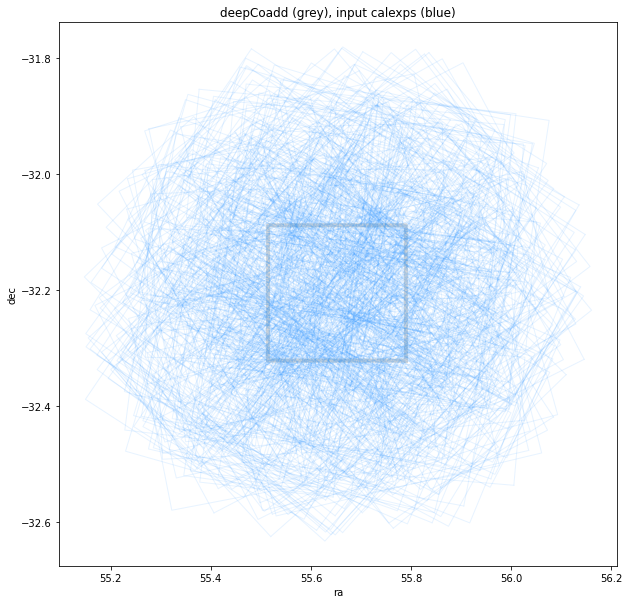

In [15]:
fig = plt.figure(figsize=(10,10))

plt.plot( [corners_deepCoadd[0][0], 
           corners_deepCoadd[1][0], 
           corners_deepCoadd[2][0], 
           corners_deepCoadd[3][0], 
           corners_deepCoadd[0][0]], 
          [corners_deepCoadd[0][1], 
           corners_deepCoadd[1][1], 
           corners_deepCoadd[2][1], 
           corners_deepCoadd[3][1],
           corners_deepCoadd[0][1]],
          lw=4, alpha=0.3, color='grey' )

for i in range(len(coadd_inputs_ccds_table)):    
    plt.plot( [corners_all_ccds[i][0][0], 
               corners_all_ccds[i][1][0], 
               corners_all_ccds[i][2][0], 
               corners_all_ccds[i][3][0], 
               corners_all_ccds[i][0][0]], 
              [corners_all_ccds[i][0][1], 
               corners_all_ccds[i][1][1], 
               corners_all_ccds[i][2][1], 
               corners_all_ccds[i][3][1],
               corners_all_ccds[i][0][1]],
              lw=1, alpha=0.1, color='dodgerblue' )

plt.xlabel( 'ra' )
plt.ylabel( 'dec' )
# plt.xlim([])
# plt.ylim([])
plt.title( 'deepCoadd (grey), input calexps (blue)' )
plt.show()

## recreate the coadd with the calexps

TBD